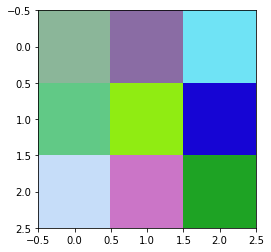

In [1]:
import torch
import cv2
import numpy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sort import Sort
import distinctipy

sample_img = np.random.rand(3,3,3)
plt.imshow(sample_img)

In [2]:
device = 'cuda:0'

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True).to(device)
model.float()
model.eval()
1

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-12-22 Python-3.8.12 torch-1.11.0 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


1

In [3]:
from pathlib import Path

data_dir = Path('/app/notebooks/object_tracking/data/_results/ref_vid')

In [4]:
img1 = cv2.imread(str(data_dir / '0.png'))
img2 = cv2.imread(str(data_dir / '1.png'))
img3 = cv2.imread(str(data_dir / '150.png'))

In [5]:
preds_1 = model(img1).pred[0][:, :4]
preds_2 = model(img2).pred[0][:, :4]
preds_3 = model(img3).pred[0][:, :4]

In [6]:
model(img1).pred[0][3]

tensor([185.66415, 205.28262, 225.59933, 324.11496,   0.78191,   0.00000], device='cuda:0')

In [7]:
import torch
from torchvision.ops import box_iou
from scipy.optimize import linear_sum_assignment

def hungarian_match(bboxs1, bboxs2):
    """
    bboxs1: m x 4
    bboxs2: n x 4
    returns: m x 1
    """
    ious = box_iou(bboxs1,bboxs2).cpu().numpy()
    return linear_sum_assignment(-ious) # row_ind, col_ind

def color_t(idx):
    state = np.random.get_state()
    numpy.random.seed(seed=idx)
    val = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
    np.random.set_state(state)
    return val

def draw_bboxes_over_image(img, bboxes, ids):
    result = numpy.copy(img)
    for j in range(len(ids)):
        bbox_id = ids[j]
        x1, y1, x2, y2 = int(bboxes[bbox_id][0]), int(bboxes[bbox_id][1]), int(bboxes[bbox_id][2]), int(bboxes[bbox_id][3])

        name_idx = int(j)

        name = f"ID:{name_idx}"
        color = color_t(name_idx)

        cv2.rectangle(result, (x1, y1), (x2, y2), color, 2)
        cv2.putText(result, name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    return result

hungarian_match(preds_2,preds_1)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25]),
 array([ 0,  1,  2,  3,  4,  5,  7,  8,  6,  9, 12, 10, 11, 13, 16, 17, 18, 15, 14, 19, 21, 20, 22, 23, 24]))

In [58]:
def update_trackers(trackers, detections):
    if len(trackers) == 0: 
        trks_inds = torch.arange(len(detections)).unsqueeze(-1).to(device)
        return torch.cat([detections, trks_inds], dim=-1)
    
    max_id = trackers[..., 4].max().item()
    
    row_ind, col_ind = hungarian_match(trackers[..., :4], detections)
    
    new_detection_ind = set(range(len(detections))) - set(col_ind) 
    print(new_detection_ind)
    # lost_trackers_ind = set(range(len(trackers))) - set(row_ind) 
    
    tracked_ind = set(row_ind)
    
    print(len(trackers))
    trackers[list(row_ind), :4] = detections[list(col_ind)]
    print(len(trackers))
    trackers = trackers[list(tracked_ind)]
    print(len(trackers))
    
    new_detected = detections[list(new_detection_ind)]
    new_trackers_inds = torch.arange(max_id, max_id+len(new_detected)).unsqueeze(-1).to(device)
    new_trackers = torch.cat([new_detected,new_trackers_inds], dim=-1)
    
    trackers = torch.cat([trackers, new_trackers], dim=0)
    
    return trackers

In [59]:
preds_1.shape, preds_2.shape

(torch.Size([25, 4]), torch.Size([26, 4]))

In [60]:
with torch.inference_mode():
    qwe = update_trackers([], preds_2)
    
    qwe1 = update_trackers(qwe, preds_2)

set()
26
26
26


In [61]:
qwe1

tensor([[594.46350, 156.45927, 731.13019, 286.75482,   0.00000],
        [ 47.93761, 274.08740,  90.43002, 396.17566,   1.00000],
        [865.49036, 227.92548, 902.95740, 339.52557,   2.00000],
        [185.66415, 205.28262, 225.59933, 324.11496,   3.00000],
        [523.70612,  65.80659, 553.62219, 156.99939,   4.00000],
        [550.74365, 105.36934, 580.27600, 191.10649,   5.00000],
        [675.69659, 286.01501, 726.68933, 405.58112,   6.00000],
        [395.42957,  72.63705, 426.40930, 159.83484,   7.00000],
        [553.95831, 488.67178, 585.72388, 539.70972,   8.00000],
        [863.04108, 439.57385, 918.15216, 508.86646,   9.00000],
        [136.31943, 188.97253, 162.61821, 294.99033,  10.00000],
        [623.86511,  72.98964, 699.33630, 136.44672,  11.00000],
        [816.34900, 132.47372, 850.65765, 223.68329,  12.00000],
        [894.81573, 100.19208, 927.12543, 194.35414,  13.00000],
        [272.55103,  70.34826, 301.91391, 163.70016,  14.00000],
        [786.90491, 386.3

In [32]:
qwe.shape

torch.Size([25, 4])

In [20]:
preds_1[:, 5] = torch.range(0, len(preds_1)).to(device)

IndexError: index 5 is out of bounds for dimension 1 with size 4

In [18]:
torch.cat([preds_1, torch.range(0, len(preds_1)).to(torch.int).to(device)])

RuntimeError: Tensors must have same number of dimensions: got 2 and 1

In [11]:
trakers = []
row_ind, col_ind = hungarian_match(preds_1, preds_2)



In [120]:
row_ind, col_ind = hungarian_match(preds_1, preds_2)

img1_with_bboxes = draw_bboxes_over_image(img1, preds_1.cpu().numpy(), row_ind)
img2_with_bboxes = draw_bboxes_over_image(img2, preds_2.cpu().numpy(), col_ind)

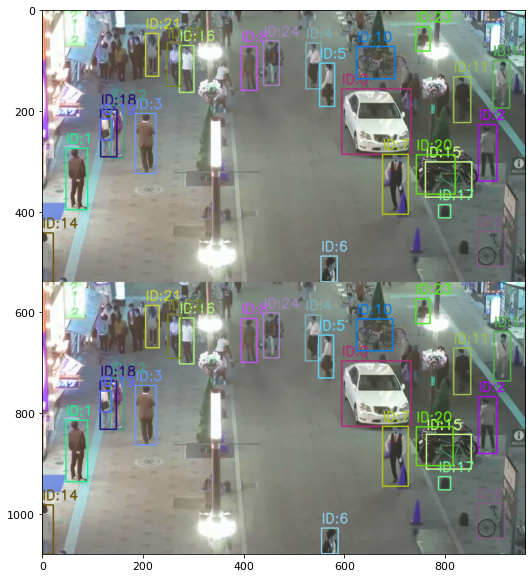

In [121]:
plt.figure(figsize=(10,10))    
plt.imshow(np.concatenate((img1_with_bboxes, img2_with_bboxes), axis=0))